In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [3]:
ids = next(os.walk("competition_data/train/images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))


No. of images =  4000


In [4]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)


In [29]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("competition_data/train/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("competition_data/train/masks/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    print(x_img)
    print(mask)
    X[n] = x_img/255.0
    y[n] = mask/65535.0


/tmp/ipykernel_13559/4220244967.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/4000 [00:00<?, ?it/s]

[[[145.63388]
  [162.80469]
  [162.38188]
  ...
  [149.85844]
  [150.28125]
  [134.43127]]

 [[162.19319]
  [180.3818 ]
  [179.79967]
  ...
  [166.48326]
  [166.63281]
  [149.05826]]

 [[161.06454]
  [179.0106 ]
  [178.52734]
  ...
  [165.52734]
  [165.22824]
  [147.22377]]

 ...

 [[180.59747]
  [202.57422]
  [203.13988]
  ...
  [174.88597]
  [173.34709]
  [153.48549]]

 [[175.79286]
  [197.20312]
  [197.99219]
  ...
  [178.84262]
  [175.33392]
  [153.62177]]

 [[151.23518]
  [169.6779 ]
  [170.38374]
  ...
  [161.71448]
  [156.06775]
  [135.23146]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [   

[[[ 82.419174]
  [100.08617 ]
  [102.49721 ]
  ...
  [ 84.6555  ]
  [ 84.50525 ]
  [ 71.21657 ]]

 [[ 89.690735]
  [109.15234 ]
  [111.84766 ]
  ...
  [ 95.92914 ]
  [ 93.17099 ]
  [ 75.944305]]

 [[ 87.29018 ]
  [106.145645]
  [108.69141 ]
  ...
  [ 98.14287 ]
  [ 92.76787 ]
  [ 72.97768 ]]

 ...

 [[ 95.94197 ]
  [104.842636]
  [102.7554  ]
  ...
  [ 95.      ]
  [ 95.      ]
  [ 84.98047 ]]

 [[ 87.608154]
  [ 94.77054 ]
  [ 92.33537 ]
  ...
  [ 94.68359 ]
  [ 94.78371 ]
  [ 84.98047 ]]

 [[ 69.616196]
  [ 74.15524 ]
  [ 72.45703 ]
  ...
  [ 84.08594 ]
  [ 84.36897 ]
  [ 76.017685]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[61.614334]
  [78.051346]
  [87.79335 ]
  ...
  [72.229904]
  [79.99765 ]
  [79.21843 ]]

 [[75.60536 ]
  [89.16583 ]
  [96.49162 ]
  ...
  [67.07422 ]
  [79.00221 ]
  [85.501114]]

 [[84.63803 ]
  [92.1445  ]
  [93.93933 ]
  ...
  [50.493515]
  [62.95758 ]
  [75.207016]]

 ...

 [[87.61514 ]
  [98.02008 ]
  [98.501495]
  ...
  [97.      ]
  [97.      ]
  [86.76953 ]]

 [[86.76953 ]
  [98.36719 ]
  [99.      ]
  ...
  [97.      ]
  [97.      ]
  [86.76953 ]]

 [[77.61806 ]
  [87.99252 ]
  [88.55859 ]
  ...
  [86.76953 ]
  [86.76953 ]
  [77.61806 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [655

[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]]
[[[111.225876]
  [127.39732 ]
  [127.12128 ]
  ...
  [138.89694 ]
  [130.95448 ]
  [ 93.62178 ]]

 [[135.34677 ]
  [149.58235 ]
  [144.6328  ]
  ...
  [153.16124 ]
  [150.85925 ]
  [111.99811 ]]

 [[151.43436 ]
  [162.60266 ]
  [153.86179 ]
  ...
  [147.63797 ]
  [153.60153 ]
  [120.045395]]

 ...

 [[111.93172 ]
  [151.63953 ]
  [165.57738 ]
  ...
  [130.03217 ]
  [125.98775 ]
  [116.85863 ]]

 [[129.58124 ]
  [166.62222 ]
  [178.28683 ]

[[[ 51.211914]
  [ 65.19945 ]
  [ 85.79114 ]
  ...
  [ 92.68881 ]
  [ 84.22221 ]
  [ 70.41638 ]]

 [[ 62.753464]
  [ 87.91777 ]
  [110.52341 ]
  ...
  [ 99.09372 ]
  [ 99.55968 ]
  [ 94.00615 ]]

 [[ 71.22006 ]
  [103.75392 ]
  [122.97017 ]
  ...
  [ 96.58827 ]
  [107.68637 ]
  [107.846924]]

 ...

 [[ 72.45703 ]
  [ 81.      ]
  [ 82.194565]
  ...
  [ 77.      ]
  [ 77.782364]
  [ 71.090775]]

 [[ 72.45703 ]
  [ 81.      ]
  [ 82.56752 ]
  ...
  [ 77.166855]
  [ 77.849106]
  [ 70.66797 ]]

 [[ 64.81508 ]
  [ 72.45703 ]
  [ 74.148254]
  ...
  [ 69.35063 ]
  [ 70.05647 ]
  [ 63.214706]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [6

[[[ 80.018616]
  [ 90.67612 ]
  [ 92.0878  ]
  ...
  [ 60.40532 ]
  [ 61.11116 ]
  [ 55.212845]]

 [[ 90.67612 ]
  [103.201675]
  [104.349884]
  ...
  [ 66.44588 ]
  [ 66.04933 ]
  [ 59.276672]]

 [[ 92.510605]
  [105.46875 ]
  [106.86478 ]
  ...
  [ 67.586685]
  [ 66.26842 ]
  [ 58.990143]]

 ...

 [[102.626495]
  [107.530136]
  [ 98.05469 ]
  ...
  [101.9483  ]
  [102.33371 ]
  [ 92.18564 ]]

 [[ 95.568085]
  [ 99.31641 ]
  [ 89.84096 ]
  ...
  [ 99.97322 ]
  [102.30034 ]
  [ 93.314285]]

 [[ 80.018616]
  [ 82.72667 ]
  [ 74.53961 ]
  ...
  [ 87.339096]
  [ 90.8683  ]
  [ 84.01955 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[101.62364 ]
  [122.16641 ]
  [128.66574 ]
  ...
  [206.165   ]
  [206.5913  ]
  [186.44337 ]]

 [[116.66295 ]
  [139.98828 ]
  [145.31528 ]
  ...
  [198.1328  ]
  [200.4385  ]
  [180.29697 ]]

 [[112.58165 ]
  [123.1478  ]
  [122.117935]
  ...
  [173.93434 ]
  [176.41463 ]
  [157.55281 ]]

 ...

 [[138.75018 ]
  [153.45647 ]
  [156.12001 ]
  ...
  [180.88464 ]
  [174.82367 ]
  [154.00613 ]]

 [[136.19588 ]
  [153.51695 ]
  [157.31415 ]
  ...
  [174.66017 ]
  [169.25793 ]
  [151.73137 ]]

 [[113.626434]
  [131.9154  ]
  [140.52177 ]
  ...
  [138.92839 ]
  [137.66696 ]
  [126.42941 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 76.017685]
  [ 95.9874  ]
  [104.46448 ]
  ...
  [ 94.544266]
  [ 96.08873 ]
  [ 83.21936 ]]

 [

[[[132.8309 ]
  [146.6577 ]
  [145.8086 ]
  ...
  [167.22842]
  [165.81674]
  [147.23425]]

 [[148.49219]
  [163.94922]
  [163.     ]
  ...
  [184.57143]
  [183.3164 ]
  [162.75926]]

 [[148.49219]
  [163.94922]
  [163.     ]
  ...
  [180.63672]
  [179.6808 ]
  [159.79613]]

 ...

 [[165.48828]
  [188.77846]
  [192.83893]
  ...
  [154.27809]
  [153.26562]
  [136.4894 ]]

 [[165.48828]
  [188.88527]
  [191.65291]
  ...
  [156.90514]
  [156.26562]
  [139.17299]]

 [[148.03444]
  [168.54576]
  [169.96094]
  ...
  [143.125  ]
  [142.84196]
  [127.2296 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [   

[[[ 96.02234 ]
  [107.34375 ]
  [110.7262  ]
  ...
  [144.39342 ]
  [142.55893 ]
  [126.42941 ]]

 [[107.34375 ]
  [125.140305]
  [132.2701  ]
  ...
  [154.58203 ]
  [151.23349 ]
  [131.552   ]]

 [[111.149   ]
  [130.80412 ]
  [137.69473 ]
  ...
  [141.76729 ]
  [139.08649 ]
  [120.68135 ]]

 ...

 [[ 97.11255 ]
  [102.23659 ]
  [102.61719 ]
  ...
  [110.802444]
  [104.51395 ]
  [ 89.17708 ]]

 [[ 89.215515]
  [ 98.26305 ]
  [100.890625]
  ...
  [118.72377 ]
  [111.11618 ]
  [ 94.117966]]

 [[ 77.61806 ]
  [ 89.215515]
  [ 93.3073  ]
  ...
  [111.99461 ]
  [104.5134  ]
  [ 88.02048 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[58.41359 ]
  [64.07779 ]
  [63.51172 ]
  ...
  [42.287567]
  [50.761154]
  [53.612473]]

 [[65.30

[[[121.628296]
  [131.07678 ]
  [129.65811 ]
  ...
  [ 94.02362 ]
  [ 96.280914]
  [ 87.22029 ]]

 [[136.58025 ]
  [147.68214 ]
  [145.9894  ]
  ...
  [ 80.5     ]
  [ 83.02344 ]
  [ 75.49005 ]]

 [[128.40717 ]
  [140.05414 ]
  [139.80377 ]
  ...
  [ 67.94066 ]
  [ 70.3884  ]
  [ 63.60956 ]]

 ...

 [[132.5898  ]
  [145.9983  ]
  [131.39096 ]
  ...
  [130.93509 ]
  [121.2729  ]
  [101.634125]]

 [[164.88727 ]
  [187.39095 ]
  [179.40901 ]
  ...
  [114.19646 ]
  [109.97189 ]
  [ 97.413055]]

 [[158.43686 ]
  [184.45514 ]
  [183.2007  ]
  ...
  [ 93.502975]
  [ 96.19006 ]
  [ 90.421036]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[108.02513 ]
  [115.86975 ]
  [112.33705 ]
  ...
  [107.29483 ]
  [101.63762 ]
  [ 81.61899 ]]

 [

[[[ 90.421036]
  [103.528015]
  [103.814545]
  ...
  [ 96.28441 ]
  [100.66272 ]
  [ 94.42197 ]]

 [[ 98.63605 ]
  [111.1308  ]
  [108.64731 ]
  ...
  [ 93.03291 ]
  [ 98.677795]
  [ 91.49028 ]]

 [[ 86.93376 ]
  [ 95.891174]
  [ 94.192566]
  ...
  [ 85.55153 ]
  [ 90.423004]
  [ 81.59802 ]]

 ...

 [[101.37555 ]
  [113.65123 ]
  [114.07588 ]
  ...
  [ 90.24626 ]
  [ 95.145645]
  [ 89.68025 ]]

 [[101.920654]
  [114.80267 ]
  [116.44754 ]
  ...
  [ 88.9626  ]
  [ 90.94664 ]
  [ 83.89375 ]]

 [[ 82.419174]
  [ 94.5827  ]
  [ 97.40607 ]
  ...
  [ 82.247955]
  [ 80.83627 ]
  [ 71.21657 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 73.61713 ]
  [ 82.296875]
  [ 82.296875]
  ...
  [ 82.296875]
  [ 82.296875]
  [ 73.61713 ]]

 [

[[[ 44.810425]
  [ 51.928238]
  [ 52.777344]
  ...
  [107.036255]
  [121.14609 ]
  [116.02699 ]]

 [[ 73.94209 ]
  [ 85.17824 ]
  [ 86.34375 ]
  ...
  [131.88617 ]
  [145.50201 ]
  [137.04498 ]]

 [[105.69795 ]
  [120.57143 ]
  [121.464096]
  ...
  [145.53033 ]
  [156.3566  ]
  [144.24666 ]]

 ...

 [[ 82.7686  ]
  [ 92.52734 ]
  [ 93.94531 ]
  ...
  [182.05768 ]
  [185.27623 ]
  [169.11533 ]]

 [[ 85.17265 ]
  [ 95.64743 ]
  [ 97.11607 ]
  ...
  [181.48717 ]
  [185.99855 ]
  [170.24397 ]]

 [[ 80.018616]
  [ 90.67612 ]
  [ 92.0878  ]
  ...
  [162.05692 ]
  [166.575   ]
  [152.83556 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[108.02513 ]
  [120.76172 ]
  [121.184525]
  ...
  [119.86719 ]
  [119.86719 ]
  [107.224945]]

 [

[[[ 86.420105]
  [ 94.77489 ]
  [ 93.08017 ]
  ...
  [176.51617 ]
  [187.53358 ]
  [179.2417  ]]

 [[ 95.99788 ]
  [105.732925]
  [104.37779 ]
  ...
  [182.2143  ]
  [192.5894  ]
  [183.86461 ]]

 [[ 95.71484 ]
  [105.63281 ]
  [104.52734 ]
  ...
  [154.09508 ]
  [160.66185 ]
  [152.12273 ]]

 ...

 [[136.53831 ]
  [151.59264 ]
  [150.61087 ]
  ...
  [118.70703 ]
  [112.09543 ]
  [ 94.80284 ]]

 [[138.36931 ]
  [153.10011 ]
  [151.42188 ]
  ...
  [103.41965 ]
  [ 97.40625 ]
  [ 82.24097 ]]

 [[123.22867 ]
  [135.92332 ]
  [134.2286  ]
  ...
  [ 82.150116]
  [ 77.349   ]
  [ 64.81508 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 74.41731 ]
  [ 88.083374]
  [ 87.388016]
  ...
  [ 95.1942  ]
  [ 92.22757 ]
  [ 79.21843 ]]

 [[ 93.58684 ]
  [107.28604 ]
  [107.79578 ]
  ...
  [ 96.88504 ]
  [ 96.59407 ]
  [ 87.3356  ]]

 [[ 89.09671 ]
  [ 98.707016]
  [ 99.882645]
  ...
  [ 79.882645]
  [ 80.473206]
  [ 76.19939 ]]

 ...

 [[ 67.984375]
  [ 76.      ]
  [ 76.      ]
  ...
  [ 65.94531 ]
  [ 65.2991  ]
  [ 58.990143]]

 [[ 67.984375]
  [ 76.      ]
  [ 76.      ]
  ...
  [ 65.94531 ]
  [ 65.      ]
  [ 58.14453 ]]

 [[ 60.814148]
  [ 67.984375]
  [ 67.984375]
  ...
  [ 58.990143]
  [ 58.14453 ]
  [ 52.0121  ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [6

[[[172.04002 ]
  [180.0943  ]
  [166.40028 ]
  ...
  [168.2208  ]
  [169.34944 ]
  [152.03537 ]]

 [[182.54028 ]
  [192.25983 ]
  [179.10883 ]
  ...
  [197.87334 ]
  [196.65436 ]
  [174.8529  ]]

 [[169.1328  ]
  [179.10603 ]
  [168.29596 ]
  ...
  [204.72955 ]
  [200.57144 ]
  [175.84877 ]]

 ...

 [[ 58.04669 ]
  [ 58.09207 ]
  [ 50.665558]
  ...
  [111.33743 ]
  [117.686386]
  [111.10008 ]]

 [[ 55.223328]
  [ 55.798325]
  [ 48.47377 ]
  ...
  [101.27232 ]
  [108.4673  ]
  [103.33583 ]]

 [[ 47.210983]
  [ 47.885376]
  [ 41.81584 ]
  ...
  [ 82.96428 ]
  [ 89.88292 ]
  [ 86.420105]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 90.421036]
  [ 91.90959 ]
  [ 82.16759 ]
  ...
  [ 67.26805 ]
  [ 64.032364]
  [ 60.01396 ]]

 [

[[[101.62364 ]
  [109.93649 ]
  [107.39267 ]
  ...
  [110.30339 ]
  [106.77768 ]
  [ 94.42197 ]]

 [[114.216965]
  [122.64743 ]
  [119.6942  ]
  ...
  [125.60771 ]
  [119.83449 ]
  [105.55469 ]]

 [[114.5     ]
  [122.53125 ]
  [119.30394 ]
  ...
  [129.92877 ]
  [121.81586 ]
  [105.97749 ]]

 ...

 [[109.929504]
  [125.662384]
  [130.27975 ]
  ...
  [ 87.83128 ]
  [ 80.28291 ]
  [ 67.75725 ]]

 [[107.389175]
  [123.90134 ]
  [129.46484 ]
  ...
  [ 98.18695 ]
  [ 90.0654  ]
  [ 74.67589 ]]

 [[ 94.42197 ]
  [109.83516 ]
  [115.19885 ]
  ...
  [ 94.62463 ]
  [ 88.1288  ]
  [ 72.81694 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [6

[[[ 92.821594]
  [109.26909 ]
  [102.937485]
  ...
  [137.10788 ]
  [141.90201 ]
  [128.02979 ]]

 [[111.71507 ]
  [127.76796 ]
  [117.56026 ]
  ...
  [143.01953 ]
  [150.10925 ]
  [138.84453 ]]

 [[120.89101 ]
  [131.98825 ]
  [119.3553  ]
  ...
  [132.32646 ]
  [140.29463 ]
  [133.05803 ]]

 ...

 [[126.74739 ]
  [161.97491 ]
  [173.37392 ]
  ...
  [115.94498 ]
  [126.97545 ]
  [123.68991 ]]

 [[131.68828 ]
  [161.45816 ]
  [167.00392 ]
  ...
  [119.89789 ]
  [133.81004 ]
  [129.89922 ]]

 [[121.628296]
  [144.5297  ]
  [145.53255 ]
  ...
  [110.988266]
  [124.39575 ]
  [120.02792 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[196.04561 ]
  [205.09575 ]
  [183.36493 ]
  ...
  [102.49721 ]
  [103.48259 ]
  [ 92.02141 ]]

 [

[[[53.612473]
  [59.933594]
  [60.3564  ]
  ...
  [63.57811 ]
  [66.51329 ]
  [48.01117 ]]

 [[56.876114]
  [64.51663 ]
  [64.45256 ]
  ...
  [68.56415 ]
  [76.15524 ]
  [56.11786 ]]

 [[54.615326]
  [61.129456]
  [60.21875 ]
  ...
  [65.09076 ]
  [76.61717 ]
  [58.941223]]

 ...

 [[57.25    ]
  [63.316406]
  [63.472656]
  ...
  [63.      ]
  [62.20703 ]
  [53.20015 ]]

 [[57.25    ]
  [63.5327  ]
  [63.63951 ]
  ...
  [62.51004 ]
  [61.51808 ]
  [52.777344]]

 [[51.211914]
  [57.25    ]
  [57.25    ]
  ...
  [55.883743]
  [54.61183 ]
  [47.210983]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [   

[[[ 90.421036]
  [102.30502 ]
  [103.2939  ]
  ...
  [129.93765 ]
  [158.72688 ]
  [160.03723 ]]

 [[ 94.96707 ]
  [ 99.58714 ]
  [ 91.52284 ]
  ...
  [ 81.58212 ]
  [ 95.869446]
  [ 97.577286]]

 [[ 82.83499 ]
  [ 85.578705]
  [ 76.77626 ]
  ...
  [ 65.20528 ]
  [ 60.69258 ]
  [ 54.43712 ]]

 ...

 [[114.20299 ]
  [127.94301 ]
  [128.8273  ]
  ...
  [108.25391 ]
  [105.563614]
  [ 92.88449 ]]

 [[ 88.13928 ]
  [107.7384  ]
  [116.92412 ]
  ...
  [105.125565]
  [102.9346  ]
  [ 90.63069 ]]

 [[ 83.21936 ]
  [ 97.92322 ]
  [103.14714 ]
  ...
  [ 92.559525]
  [ 91.85368 ]
  [ 81.61899 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 86.420105]
  [ 94.16339 ]
  [100.21895 ]
  ...
  [ 95.1942  ]
  [ 91.944534]
  [ 78.41824 ]]

 [

[[[120.02792 ]
  [132.3452  ]
  [131.07329 ]
  ...
  [114.028275]
  [112.75636 ]
  [ 99.22308 ]]

 [[137.23717 ]
  [150.43259 ]
  [148.90123 ]
  ...
  [135.99889 ]
  [134.2539  ]
  [118.25983 ]]

 [[144.99443 ]
  [158.67188 ]
  [156.64304 ]
  ...
  [143.27975 ]
  [142.13113 ]
  [125.88431 ]]

 ...

 [[149.11067 ]
  [165.97043 ]
  [163.471   ]
  ...
  [117.88597 ]
  [117.469864]
  [104.757996]]

 [[151.50424 ]
  [167.35112 ]
  [163.73158 ]
  ...
  [122.6875  ]
  [121.69821 ]
  [107.864395]]

 [[134.43127 ]
  [147.22377 ]
  [143.69456 ]
  ...
  [114.028275]
  [112.75636 ]
  [ 99.22308 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 86.420105]
  [ 93.551895]
  [ 92.13672 ]
  ...
  [114.54892 ]
  [115.67757 ]
  [104.0242  ]]

 [

[[[ 77.61806 ]
  [ 87.99252 ]
  [ 88.9814  ]
  ...
  [ 89.03032 ]
  [ 89.73616 ]
  [ 80.8188  ]]

 [[ 96.55347 ]
  [107.90279 ]
  [108.03627 ]
  ...
  [ 99.85045 ]
  [100.10011 ]
  [ 89.73616 ]]

 [[ 97.27678 ]
  [108.385605]
  [107.77194 ]
  ...
  [ 99.75075 ]
  [ 99.52734 ]
  [ 89.03032 ]]

 ...

 [[ 77.45033 ]
  [ 88.6702  ]
  [ 91.080536]
  ...
  [ 91.00008 ]
  [ 97.45148 ]
  [ 92.26601 ]]

 [[ 80.13393 ]
  [ 92.96529 ]
  [ 96.57143 ]
  ...
  [ 71.040146]
  [ 79.632   ]
  [ 75.731155]]

 [[ 74.41731 ]
  [ 87.47188 ]
  [ 91.567154]
  ...
  [ 56.876114]
  [ 56.163284]
  [ 46.410797]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 66.41545 ]
  [ 71.80011 ]
  [ 71.51358 ]
  ...
  [ 72.034225]
  [ 72.45703 ]
  [ 64.81508 ]]

 [

[[[115.22681 ]
  [126.366516]
  [123.54315 ]
  ...
  [133.383   ]
  [136.20636 ]
  [124.028854]]

 [[127.58951 ]
  [139.43114 ]
  [135.41238 ]
  ...
  [147.02121 ]
  [149.74754 ]
  [136.81786 ]]

 [[126.177826]
  [137.31361 ]
  [132.7461  ]
  ...
  [142.77194 ]
  [145.44699 ]
  [132.5863  ]]

 ...

 [[ 68.976746]
  [ 80.48996 ]
  [ 88.396774]
  ...
  [ 99.34375 ]
  [ 93.50391 ]
  [ 78.7502  ]]

 [[ 72.083145]
  [ 83.10011 ]
  [ 89.488846]
  ...
  [ 87.212616]
  [ 81.8721  ]
  [ 68.73215 ]]

 [[ 67.21564 ]
  [ 76.97511 ]
  [ 81.62947 ]
  ...
  [ 70.098404]
  [ 66.28616 ]
  [ 56.01303 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 90.421036]
  [102.30502 ]
  [104.13951 ]
  ...
  [105.37648 ]
  [112.8577  ]
  [106.42476 ]]

 [[103.528015]
  [117.10156 ]
  [118.82924 ]
  ...
  [120.53516 ]
  [128.89844 ]
  [121.41864 ]]

 [[107.19699 ]
  [121.203125]
  [123.004654]
  ...
  [125.109375]
  [133.17355 ]
  [124.66481 ]]

 ...

 [[116.95647 ]
  [141.3231  ]
  [152.11403 ]
  ...
  [171.21875 ]
  [171.3644  ]
  [151.74535 ]]

 [[122.176895]
  [146.18706 ]
  [156.15514 ]
  ...
  [174.83705 ]
  [174.7837  ]
  [154.70848 ]]

 [[112.02606 ]
  [132.57233 ]
  [140.61961 ]
  ...
  [157.90923 ]
  [157.76596 ]
  [140.03258 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 75.2175  ]
  [ 85.920425]
  [ 88.460754]
  ...
  [ 93.92578 ]
  [ 95.05792 ]
  [ 87.22029 ]]

 [[ 88.977905]
  [101.51953 ]
  [104.359375]
  ...
  [102.626114]
  [104.43114 ]
  [ 96.280914]]

 [[ 94.20183 ]
  [107.03627 ]
  [109.279755]
  ...
  [102.94531 ]
  [105.      ]
  [ 96.98326 ]]

 ...

 [[ 82.91536 ]
  [ 89.994415]
  [ 89.49385 ]
  ...
  [107.21875 ]
  [112.11998 ]
  [104.28627 ]]

 [[ 88.42232 ]
  [ 97.445755]
  [ 98.6635  ]
  ...
  [108.796875]
  [113.84766 ]
  [106.12076 ]]

 [[ 84.01955 ]
  [ 93.92578 ]
  [ 96.462616]
  ...
  [ 98.5452  ]
  [103.06328 ]
  [ 96.02234 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[120.82811]
  [116.11784]
  [103.5385 ]
  ...
  [133.12093]
  [124.81506]
  [116.02699]]

 [[142.41217]
  [140.81552]
  [128.05078]
  ...
  [141.55856]
  [133.33618]
  [117.47711]]

 [[143.69456]
  [146.13171]
  [136.50449]
  ...
  [132.06392]
  [126.93306]
  [105.47432]]

 ...

 [[168.59468]
  [177.31085]
  [166.12001]
  ...
  [138.73013]
  [176.69363]
  [176.36942]]

 [[164.77545]
  [167.00113]
  [150.25615]
  ...
  [138.49385]
  [176.34306]
  [172.96251]]

 [[140.83276]
  [137.86963]
  [119.51077]
  ...
  [120.44025]
  [150.33716]
  [143.23332]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[104.0242  ]
  [115.06607 ]
  [113.23158 ]
  ...
  [ 93.502975]
  [ 94.49185 ]
  [ 85.61992 ]]

 [[115.67757 ]
  [127.94922 ]
  [126.2

[[[120.02792 ]
  [134.17969 ]
  [134.6025  ]
  ...
  [ 69.72452 ]
  [ 69.16194 ]
  [ 62.41452 ]]

 [[127.45323 ]
  [142.94777 ]
  [144.28293 ]
  ...
  [ 88.31137 ]
  [ 90.48627 ]
  [ 83.22635 ]]

 [[118.42056 ]
  [133.71262 ]
  [136.4163  ]
  ...
  [100.250916]
  [104.91629 ]
  [ 97.486435]]

 ...

 [[ 88.88356 ]
  [ 95.73436 ]
  [ 94.15808 ]
  ...
  [129.33743 ]
  [131.74777 ]
  [119.72043 ]]

 [[ 89.03381 ]
  [ 99.89441 ]
  [102.85043 ]
  ...
  [122.44588 ]
  [126.35112 ]
  [116.05145 ]]

 [[ 84.01955 ]
  [ 97.59476 ]
  [103.52103 ]
  ...
  [104.38411 ]
  [109.325   ]
  [101.62364 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[109.6255  ]
  [122.55078 ]
  [122.55078 ]
  ...
  [104.66016 ]
  [105.22623 ]
  [ 95.22215 ]]

 [[120.1048  ]
  [134.26562 ]
  [134.26562 ]
  ...
  [115.9933  ]
  [116.732925]
  [105.22623 ]]

 [[116.43582 ]
  [130.16406 ]
  [130.16406 ]
  ...
  [114.109375]
  [114.748886]
  [102.96893 ]]

 ...

 [[ 44.467987]
  [ 42.800232]
  [ 37.633392]
  ...
  [132.16406 ]
  [132.48717 ]
  [118.224884]]

 [[ 64.51807 ]
  [ 63.70558 ]
  [ 56.051346]
  ...
  [136.42578 ]
  [136.99855 ]
  [122.742966]]

 [[ 75.2175  ]
  [ 76.13649 ]
  [ 68.22897 ]
  ...
  [125.7061  ]
  [126.41194 ]
  [113.626434]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 88.02048 ]
  [100.232925]
  [108.26973 ]
  ...
  [124.61589 ]
  [121.09018 ]
  [107.224945]]

 [[ 90.44899 ]
  [103.16406 ]
  [114.41017 ]
  ...
  [136.21373 ]
  [132.3818  ]
  [118.0327  ]]

 [[ 80.00464 ]
  [ 94.71933 ]
  [110.74185 ]
  ...
  [133.61253 ]
  [130.05469 ]
  [116.33798 ]]

 ...

 [[139.12407 ]
  [155.16685 ]
  [154.52734 ]
  ...
  [131.      ]
  [131.      ]
  [117.18359 ]]

 [[139.54688 ]
  [155.10011 ]
  [154.21094 ]
  ...
  [131.78236 ]
  [131.63281 ]
  [117.749664]]

 [[124.82904 ]
  [138.32388 ]
  [137.335   ]
  ...
  [119.39546 ]
  [118.97266 ]
  [106.42476 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [6

[[[ 60.01396 ]
  [ 69.53583 ]
  [ 72.782   ]
  ...
  [ 82.345795]
  [ 84.32355 ]
  [ 77.61806 ]]

 [[ 65.255356]
  [ 75.68359 ]
  [ 79.3125  ]
  ...
  [ 93.707596]
  [ 95.16551 ]
  [ 87.99252 ]]

 [[ 67.7887  ]
  [ 78.83873 ]
  [ 82.84059 ]
  ...
  [ 98.94997 ]
  [ 99.23773 ]
  [ 90.67262 ]]

 ...

 [[119.72043 ]
  [132.14565 ]
  [130.44382 ]
  ...
  [139.44215 ]
  [133.85156 ]
  [114.84244 ]]

 [[116.05145 ]
  [128.58348 ]
  [127.87723 ]
  ...
  [148.85045 ]
  [143.73293 ]
  [123.87511 ]]

 [[101.62364 ]
  [112.99397 ]
  [113.13374 ]
  ...
  [138.97731 ]
  [134.88203 ]
  [116.82718 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[104.0242  ]
  [119.95804 ]
  [124.193085]
  ...
  [103.19606 ]
  [ 99.94989 ]
  [ 87.22029 ]]

 [

[[[124.028854]
  [133.76038 ]
  [130.22768 ]
  ...
  [123.169266]
  [128.39319 ]
  [119.22774 ]]

 [[155.77423 ]
  [170.54108 ]
  [167.78014 ]
  ...
  [135.64062 ]
  [140.83159 ]
  [129.61618 ]]

 [[168.77289 ]
  [187.87613 ]
  [187.23271 ]
  ...
  [143.62018 ]
  [147.01898 ]
  [133.41444 ]]

 ...

 [[151.48328 ]
  [170.10211 ]
  [172.1462  ]
  ...
  [173.05469 ]
  [169.42578 ]
  [149.11067 ]]

 [[137.93951 ]
  [156.6865  ]
  [160.19922 ]
  ...
  [171.30078 ]
  [167.77199 ]
  [147.82478 ]]

 [[116.82718 ]
  [133.65904 ]
  [137.18825 ]
  ...
  [143.44997 ]
  [140.48683 ]
  [124.028854]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 80.8188  ]
  [ 85.45569 ]
  [ 79.80896 ]
  ...
  [ 73.97005 ]
  [ 78.6279  ]
  [ 73.61713 ]]

 [

[[[ 93.62178 ]
  [102.21417 ]
  [102.35045 ]
  ...
  [102.96893 ]
  [103.81105 ]
  [ 91.22122 ]]

 [[103.437164]
  [114.76764 ]
  [115.78516 ]
  ...
  [101.00224 ]
  [100.11183 ]
  [ 87.30066 ]]

 [[110.05879 ]
  [120.12721 ]
  [118.858795]
  ...
  [ 80.224655]
  [ 83.484344]
  [ 76.279755]]

 ...

 [[ 96.43117 ]
  [108.62056 ]
  [115.11868 ]
  ...
  [119.58502 ]
  [121.72601 ]
  [112.012085]]

 [[106.17667 ]
  [113.798004]
  [115.25896 ]
  ...
  [123.42969 ]
  [126.561935]
  [116.52667 ]]

 [[104.82439 ]
  [108.62265 ]
  [104.23735 ]
  ...
  [115.91518 ]
  [117.749664]
  [106.42476 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 58.41359 ]
  [ 65.30078 ]
  [ 65.30078 ]
  ...
  [ 62.795395]
  [ 55.597214]
  [ 44.810425]]

 [

[[[ 72.81694 ]
  [ 83.23683 ]
  [ 81.97191 ]
  ...
  [ 92.88449 ]
  [ 86.95123 ]
  [ 71.21657 ]]

 [[ 75.287384]
  [ 93.22435 ]
  [ 95.7009  ]
  ...
  [101.07753 ]
  [102.10043 ]
  [ 88.174225]]

 [[ 64.84653 ]
  [ 87.05861 ]
  [ 95.51047 ]
  ...
  [ 86.592255]
  [ 93.10098 ]
  [ 84.94902 ]]

 ...

 [[ 71.5625  ]
  [ 82.05078 ]
  [ 84.41797 ]
  ...
  [ 90.76729 ]
  [105.879486]
  [103.44066 ]]

 [[ 71.5625  ]
  [ 82.05078 ]
  [ 84.41797 ]
  ...
  [ 87.48601 ]
  [100.08147 ]
  [100.17702 ]]

 [[ 64.01489 ]
  [ 73.39699 ]
  [ 75.51451 ]
  ...
  [ 75.189545]
  [ 79.99765 ]
  [ 79.21843 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [6

[[[120.02792 ]
  [136.62567 ]
  [137.75781 ]
  ...
  [ 95.34096 ]
  [101.987045]
  [101.62364 ]]

 [[129.28772 ]
  [146.33102 ]
  [148.13338 ]
  ...
  [108.81973 ]
  [118.615295]
  [116.05145 ]]

 [[124.0638  ]
  [138.11996 ]
  [140.16705 ]
  ...
  [114.88298 ]
  [124.647354]
  [116.33798 ]]

 ...

 [[142.08371 ]
  [154.62222 ]
  [150.2569  ]
  ...
  [134.81491 ]
  [178.30968 ]
  [163.2275  ]]

 [[134.73528 ]
  [144.68504 ]
  [138.6289  ]
  ...
  [147.84984 ]
  [183.11247 ]
  [159.12523 ]]

 [[111.225876]
  [119.447876]
  [114.22395 ]
  ...
  [143.7959  ]
  [164.6287  ]
  [135.23146 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [10934.833]
  [30914.527]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[140.03258 ]
  [158.37746 ]
  [159.22656 ]
  ...
  [128.01581 ]
  [132.53738 ]
  [124.028854]]

 [[153.48549 ]
  [173.63281 ]
  [174.90514 ]
  ...
  [146.88783 ]
  [152.48192 ]
  [142.93282 ]]

 [[149.95628 ]
  [169.6875  ]
  [171.33278 ]
  ...
  [149.38448 ]
  [155.89844 ]
  [146.18248 ]]

 ...

 [[ 96.462616]
  [ 92.0759  ]
  [ 74.18526 ]
  ...
  [157.41498 ]
  [153.05635 ]
  [132.24387 ]]

 [[ 92.510605]
  [ 87.444305]
  [ 70.573654]
  ...
  [158.28459 ]
  [151.43549 ]
  [128.57489 ]]

 [[ 80.018616]
  [ 76.00021 ]
  [ 62.162933]
  ...
  [142.4576  ]
  [134.68985 ]
  [112.82625 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[100.02327 ]
  [111.81641 ]
  [111.3936  ]
  ...
  [ 99.91145 ]
  [103.7202  ]
  [ 94.42197 ]]

 [

[[[ 81.61899 ]
  [ 94.91116 ]
  [ 96.18657 ]
  ...
  [158.80376 ]
  [159.5096  ]
  [143.23332 ]]

 [[ 88.18471 ]
  [103.150894]
  [104.469864]
  ...
  [172.99052 ]
  [171.73148 ]
  [153.39464 ]]

 [[ 91.420395]
  [106.01506 ]
  [107.282745]
  ...
  [157.65625 ]
  [156.04742 ]
  [140.13391 ]]

 ...

 [[119.36401 ]
  [131.06361 ]
  [129.96484 ]
  ...
  [137.97748 ]
  [134.17802 ]
  [115.52382 ]]

 [[126.12891 ]
  [139.16551 ]
  [138.16685 ]
  ...
  [124.702576]
  [122.15637 ]
  [107.76306 ]]

 [[112.82625 ]
  [124.905914]
  [123.91704 ]
  ...
  [100.610306]
  [101.036606]
  [ 92.02141 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 79.21843 ]
  [ 95.28505 ]
  [102.20369 ]
  ...
  [109.5067  ]
  [108.23828 ]
  [ 96.822525]]

 [

[[[152.83556 ]
  [176.35893 ]
  [181.86589 ]
  ...
  [109.63599 ]
  [ 98.9086  ]
  [ 80.8188  ]]

 [[164.74051 ]
  [190.3164  ]
  [196.47266 ]
  ...
  [127.74553 ]
  [116.93895 ]
  [ 96.462616]]

 [[155.14526 ]
  [179.26674 ]
  [185.49684 ]
  ...
  [133.50482 ]
  [124.29018 ]
  [103.52103 ]]

 ...

 [[130.12984 ]
  [144.75168 ]
  [143.44681 ]
  ...
  [ 76.024185]
  [ 76.27344 ]
  [ 68.22897 ]]

 [[128.85793 ]
  [142.4673  ]
  [140.0173  ]
  ...
  [ 82.74219 ]
  [ 83.31496 ]
  [ 74.72131 ]]

 [[113.626434]
  [125.18895 ]
  [122.225815]
  ...
  [ 78.295944]
  [ 79.001785]
  [ 71.21657 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 96.02234 ]
  [113.45871 ]
  [112.061005]
  ...
  [ 97.16147 ]
  [ 84.44934 ]
  [ 62.41452 ]]

 [

[[[113.626434]
  [128.85793 ]
  [130.55264 ]
  ...
  [137.01004 ]
  [140.39598 ]
  [127.2296  ]]

 [[134.36139 ]
  [147.1136  ]
  [144.69028 ]
  ...
  [158.27232 ]
  [160.22032 ]
  [142.23047 ]]

 [[127.18767 ]
  [136.71484 ]
  [131.39935 ]
  ...
  [162.92245 ]
  [161.63283 ]
  [140.11644 ]]

 ...

 [[115.34561 ]
  [129.3058  ]
  [129.94531 ]
  ...
  [176.75706 ]
  [168.00168 ]
  [142.97824 ]]

 [[114.216965]
  [127.71831 ]
  [127.459274]
  ...
  [170.66797 ]
  [162.0884  ]
  [138.46016 ]]

 [[101.62364 ]
  [112.38248 ]
  [110.12518 ]
  ...
  [147.77586 ]
  [140.29465 ]
  [120.02792 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 51.211914]
  [ 42.574097]
  [ 29.439163]
  ...
  [116.71187 ]
  [115.15692 ]
  [100.823456]]

 [[ 49.91205 ]
  [ 41.259827]
  [ 29.05693 ]
  ...
  [131.47935 ]
  [129.41797 ]
  [113.32243 ]]

 [[ 43.13318 ]
  [ 35.193085]
  [ 25.777924]
  ...
  [132.66722 ]
  [130.38058 ]
  [113.60547 ]]

 ...

 [[ 85.875   ]
  [ 96.68359 ]
  [ 98.64137 ]
  ...
  [114.63672 ]
  [115.109375]
  [102.96893 ]]

 [[ 86.158035]
  [ 96.78371 ]
  [ 98.26842 ]
  ...
  [117.79297 ]
  [118.0654  ]
  [105.22623 ]]

 [[ 77.61806 ]
  [ 86.76953 ]
  [ 87.61514 ]
  ...
  [107.815475]
  [107.67221 ]
  [ 95.22215 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [6

[[[104.0242  ]
  [116.90056 ]
  [117.18359 ]
  ...
  [118.72806 ]
  [111.66965 ]
  [ 94.42197 ]]

 [[115.06607 ]
  [129.7837  ]
  [130.63951 ]
  ...
  [133.08705 ]
  [126.601   ]
  [109.22366 ]]

 [[114.077194]
  [128.57143 ]
  [129.52734 ]
  ...
  [132.11104 ]
  [127.39397 ]
  [111.76749 ]]

 ...

 [[107.57088 ]
  [114.026794]
  [107.13988 ]
  ...
  [ 96.36253 ]
  [113.8934  ]
  [115.233795]]

 [[ 99.520096]
  [104.16696 ]
  [ 96.95592 ]
  ...
  [123.99106 ]
  [138.50278 ]
  [133.57867 ]]

 [[ 80.8188  ]
  [ 84.84419 ]
  [ 78.49162 ]
  ...
  [130.99292 ]
  [140.30513 ]
  [130.43034 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[128.82997]
  [134.84709]
  [136.94365]
  ...
  [139.8369 ]
  [122.22232]
  [110.42569]]

 [[127.50914]
  [146.30807]
  [159.34099]
  ...
  [149.30136]
  [130.48848]
  [125.8913 ]]

 [[125.78647]
  [148.28625]
  [161.04904]
  ...
  [147.22873]
  [131.49779]
  [127.86905]]

 ...

 [[153.95721]
  [153.46542]
  [146.12466]
  ...
  [162.49518]
  [175.5441 ]
  [169.35992]]

 [[155.08237]
  [152.78995]
  [142.46986]
  ...
  [166.01953]
  [181.15971]
  [176.69788]]

 [[137.63202]
  [137.96048]
  [130.17876]
  ...
  [151.56714]
  [165.69095]
  [162.43779]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 93.62178 ]
  [ 85.092285]
  [ 77.72638 ]
  ...
  [ 95.519165]
  [ 92.13672 ]
  [ 82.419174]]

 [[108.32913 ]
  [ 94.55356 ]
  [ 84.1

[[[ 68.81601 ]
  [ 78.764175]
  [ 79.61328 ]
  ...
  [ 83.58276 ]
  [ 95.159256]
  [ 94.42197 ]]

 [[ 75.706696]
  [ 86.68359 ]
  [ 87.95592 ]
  ...
  [103.00781 ]
  [115.084045]
  [111.66965 ]]

 [[ 73.87221 ]
  [ 85.27902 ]
  [ 87.44681 ]
  ...
  [112.61087 ]
  [123.39119 ]
  [117.45964 ]]

 ...

 [[ 84.68695 ]
  [ 97.12053 ]
  [ 99.946976]
  ...
  [175.45013 ]
  [167.1568  ]
  [142.73364 ]]

 [[ 76.49989 ]
  [ 89.15379 ]
  [ 93.49832 ]
  ...
  [165.10881 ]
  [154.57466 ]
  [129.74197 ]]

 [[ 62.41452 ]
  [ 73.44241 ]
  [ 78.100266]
  ...
  [136.94365 ]
  [126.073   ]
  [104.0242  ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 71.21657 ]
  [ 77.1673  ]
  [ 81.95444 ]
  ...
  [105.22972 ]
  [107.34375 ]
  [ 96.02234 ]]

 [[ 79.001785]
  [ 90.255035]
  [101.00058 ]
  ...
  [115.90904 ]
  [117.732925]
  [104.897766]]

 [[ 80.40997 ]
  [ 97.869446]
  [113.129654]
  ...
  [113.442154]
  [115.69028 ]
  [104.61124 ]]

 ...

 [[ 93.454056]
  [103.78906 ]
  [103.24925 ]
  ...
  [124.46834 ]
  [113.941956]
  [ 87.79335 ]]

 [[ 93.314285]
  [103.41652 ]
  [102.551346]
  ...
  [119.90456 ]
  [105.076675]
  [ 78.90045 ]]

 [[ 84.01955 ]
  [ 92.70279 ]
  [ 90.8683  ]
  ...
  [101.91017 ]
  [ 86.2384  ]
  [ 64.01489 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 80.8188  ]
  [ 89.124664]
  [ 88.55859 ]
  ...
  [227.63374 ]
  [221.83327 ]
  [188.04375 ]]

 [

[[[ 68.01582 ]
  [ 86.43059 ]
  [109.84564 ]
  ...
  [ 92.00743 ]
  [ 94.10748 ]
  [ 77.61806 ]]

 [[ 75.42366 ]
  [ 87.05879 ]
  [114.29468 ]
  ...
  [104.583145]
  [107.68649 ]
  [ 89.82701 ]]

 [[ 80.214294]
  [ 80.873276]
  [104.04314 ]
  ...
  [106.99834 ]
  [110.229904]
  [ 93.35622 ]]

 ...

 [[143.84132 ]
  [157.63115 ]
  [149.37517 ]
  ...
  [120.384476]
  [133.93697 ]
  [131.9189  ]]

 [[151.88861 ]
  [165.01172 ]
  [157.4241  ]
  ...
  [115.18135 ]
  [129.4615  ]
  [132.06216 ]]

 [[142.43314 ]
  [154.94609 ]
  [148.73679 ]
  ...
  [102.64397 ]
  [114.94028 ]
  [119.22774 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 77.61806 ]
  [ 81.87756 ]
  [ 76.230835]
  ...
  [ 93.08017 ]
  [ 94.49185 ]
  [ 85.61992 ]]

 [

[[[120.82811 ]
  [136.9087  ]
  [140.71745 ]
  ...
  [107.32628 ]
  [ 95.04744 ]
  [ 76.81787 ]]

 [[133.85123 ]
  [152.1509  ]
  [157.27121 ]
  ...
  [113.94028 ]
  [102.80122 ]
  [ 84.04051 ]]

 [[132.43954 ]
  [152.08148 ]
  [158.42262 ]
  ...
  [107.887634]
  [ 99.43805 ]
  [ 82.7686  ]]

 ...

 [[105.10043 ]
  [135.91183 ]
  [152.89362 ]
  ...
  [120.62184 ]
  [112.69867 ]
  [ 94.15291 ]]

 [[118.08861 ]
  [149.35257 ]
  [164.0441  ]
  ...
  [110.79074 ]
  [104.38873 ]
  [ 88.649445]]

 [[116.02699 ]
  [144.38293 ]
  [155.40384 ]
  ...
  [ 92.412766]
  [ 88.03795 ]
  [ 76.017685]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[109.6255  ]
  [120.1048  ]
  [118.54985 ]
  ...
  [115.42598 ]
  [106.257034]
  [ 91.22122 ]]

 [

[[[ 69.616196]
  [ 77.21272 ]
  [ 76.50688 ]
  ...
  [ 94.44643 ]
  [ 96.56395 ]
  [ 88.02048 ]]

 [[ 79.04721 ]
  [ 87.68359 ]
  [ 86.89453 ]
  ...
  [113.82254 ]
  [117.05223 ]
  [106.95938 ]]

 [[ 81.304504]
  [ 89.23772 ]
  [ 88.223404]
  ...
  [122.83594 ]
  [126.76395 ]
  [116.41835 ]]

 ...

 [[104.855835]
  [115.85156 ]
  [113.55153 ]
  ...
  [146.30394 ]
  [143.6875  ]
  [126.69847 ]]

 [[109.65346 ]
  [121.43114 ]
  [119.00781 ]
  ...
  [150.63951 ]
  [147.8491  ]
  [130.22768 ]]

 [[100.823456]
  [112.09944 ]
  [110.12518 ]
  ...
  [138.1317  ]
  [135.73114 ]
  [119.22774 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[108.02513 ]
  [119.53873 ]
  [118.54985 ]
  ...
  [113.50763 ]
  [111.250336]
  [ 98.4229  ]]

 [[129.93416 ]
  [143.88672 ]
  [142.78125 ]
  ...
  [135.49162 ]
  [134.1538  ]
  [119.19978 ]]

 [[142.6358  ]
  [158.08594 ]
  [156.31026 ]
  ...
  [148.03217 ]
  [148.43582 ]
  [132.74704 ]]

 ...

 [[101.17987 ]
  [109.97713 ]
  [110.16872 ]
  ...
  [117.70238 ]
  [112.92691 ]
  [ 96.8365  ]]

 [[105.135376]
  [112.78081 ]
  [111.401794]
  ...
  [106.2567  ]
  [103.00548 ]
  [ 91.05    ]]

 [[ 98.4229  ]
  [104.52388 ]
  [101.55376 ]
  ...
  [ 86.19997 ]
  [ 84.93504 ]
  [ 77.61806 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[120.02792 ]
  [133.56819 ]
  [131.59393 ]
  ...
  [142.75111 ]
  [145.43471 ]
  [132.8309  ]]

 [

[[[ 90.421036]
  [ 94.96707 ]
  [ 87.485855]
  ...
  [ 72.278824]
  [ 80.043076]
  [ 77.61806 ]]

 [[ 94.96707 ]
  [ 99.795425]
  [ 91.97154 ]
  ...
  [ 66.656265]
  [ 74.37198 ]
  [ 75.7626  ]]

 [[ 86.21744 ]
  [ 90.55357 ]
  [ 83.575714]
  ...
  [ 62.738525]
  [ 65.68584 ]
  [ 67.70833 ]]

 ...

 [[ 85.452194]
  [ 95.88783 ]
  [ 96.05469 ]
  ...
  [ 98.75241 ]
  [100.896194]
  [ 93.534424]]

 [[ 86.158035]
  [ 96.78371 ]
  [ 97.      ]
  ...
  [ 90.00166 ]
  [ 90.0029  ]
  [ 81.95793 ]]

 [[ 77.61806 ]
  [ 86.76953 ]
  [ 86.76953 ]
  ...
  [ 72.782   ]
  [ 70.951004]
  [ 64.01489 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [6

[[[112.82625 ]
  [154.86922 ]
  [160.56137 ]
  ...
  [ 92.78665 ]
  [ 95.634476]
  [ 99.22308 ]]

 [[131.63237 ]
  [176.47745 ]
  [184.45091 ]
  ...
  [105.64116 ]
  [113.24408 ]
  [118.25983 ]]

 [[132.48846 ]
  [173.55188 ]
  [182.41464 ]
  ...
  [108.54721 ]
  [120.280136]
  [125.0387  ]]

 ...

 [[133.70796 ]
  [148.50334 ]
  [145.99236 ]
  ...
  [129.94955 ]
  [142.64842 ]
  [113.11627 ]]

 [[131.86998 ]
  [148.71573 ]
  [149.41795 ]
  ...
  [123.25444 ]
  [130.42667 ]
  [ 98.99945 ]]

 [[115.22681 ]
  [132.48148 ]
  [136.29372 ]
  ...
  [104.87331 ]
  [106.9489  ]
  [ 77.61806 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[113.626434]
  [130.69241 ]
  [136.19588 ]
  ...
  [113.979355]
  [113.56004 ]
  [103.224014]]

 [

[[[115.22681 ]
  [130.64699 ]
  [132.76451 ]
  ...
  [136.9122  ]
  [138.04085 ]
  [124.028854]]

 [[128.8125  ]
  [146.05078 ]
  [148.41797 ]
  ...
  [153.37779 ]
  [154.3164  ]
  [138.65234 ]]

 [[128.3897  ]
  [145.90123 ]
  [148.41797 ]
  ...
  [153.30394 ]
  [154.3164  ]
  [138.65234 ]]

 ...

 [[140.91313 ]
  [156.84375 ]
  [156.27809 ]
  ...
  [154.24925 ]
  [151.48326 ]
  [133.383   ]]

 [[141.33594 ]
  [157.3164  ]
  [156.52734 ]
  ...
  [156.83984 ]
  [154.      ]
  [135.92332 ]]

 [[126.42941 ]
  [140.72444 ]
  [140.0186  ]
  ...
  [142.13263 ]
  [139.5923  ]
  [123.22867 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 90.421036]
  [101.08203 ]
  [101.92764 ]
  ...
  [ 92.88449 ]
  [ 88.93248 ]
  [ 76.81787 ]]

 [[101.08203 ]
  [110.6635  ]
  [108.26561 ]
  ...
  [120.27957 ]
  [116.50781 ]
  [101.1624  ]]

 [[101.08203 ]
  [110.22824 ]
  [107.02884 ]
  ...
  [133.14154 ]
  [131.90846 ]
  [117.54001 ]]

 ...

 [[ 81.02846 ]
  [ 94.969315]
  [ 94.18068 ]
  ...
  [107.37384 ]
  [104.74216 ]
  [ 97.13002 ]]

 [[ 85.41026 ]
  [ 93.7074  ]
  [ 85.97043 ]
  ...
  [123.70482 ]
  [117.34419 ]
  [103.77611 ]]

 [[ 82.419174]
  [ 80.518295]
  [ 68.37573 ]
  ...
  [121.50949 ]
  [117.840515]
  [103.224014]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 80.018616]
  [ 89.453125]
  [ 89.453125]
  ...
  [ 89.453125]
  [ 89.453125]
  [ 80.018616]]

 [

[[[151.23518]
  [186.79979]
  [191.62537]
  ...
  [131.02437]
  [130.31853]
  [116.02699]]

 [[181.29633]
  [217.35579]
  [215.84763]
  ...
  [143.37779]
  [141.83304]
  [125.42656]]

 [[192.4535 ]
  [223.24886]
  [214.36752]
  ...
  [139.33278]
  [137.06529]
  [120.48567]]

 ...

 [[127.86905]
  [136.0346 ]
  [130.24925]
  ...
  [ 94.38281]
  [108.57924]
  [109.03497]]

 [[125.8913 ]
  [131.88237]
  [125.72098]
  ...
  [ 91.84877]
  [105.64598]
  [105.92857]]

 [[110.42569]
  [114.27287]
  [108.75893]
  ...
  [ 80.00464]
  [ 91.86417]
  [ 92.02141]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [   

[[[100.02327 ]
  [104.478455]
  [ 98.968   ]
  ...
  [116.35545 ]
  [129.19687 ]
  [123.22867 ]]

 [[118.54286 ]
  [121.979904]
  [111.50723 ]
  ...
  [136.22656 ]
  [150.58203 ]
  [143.26128 ]]

 [[126.30711 ]
  [127.9626  ]
  [112.95886 ]
  ...
  [144.24759 ]
  [157.85715 ]
  [149.19104 ]]

 ...

 [[111.57181 ]
  [119.6183  ]
  [113.72191 ]
  ...
  [117.77959 ]
  [111.42969 ]
  [ 96.00836 ]]

 [[105.64554 ]
  [113.10011 ]
  [107.626114]
  ...
  [127.07869 ]
  [122.147995]
  [106.17667 ]]

 [[ 91.22122 ]
  [ 97.084595]
  [ 92.28348 ]
  ...
  [121.98122 ]
  [119.01808 ]
  [104.82439 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[102.42383 ]
  [110.21953 ]
  [108.23828 ]
  ...
  [138.60342 ]
  [137.75781 ]
  [123.22867 ]]

 [

[[[ 94.42197 ]
  [105.55469 ]
  [105.55469 ]
  ...
  [ 95.26059 ]
  [100.88985 ]
  [ 86.420105]]

 [[106.16618 ]
  [118.68359 ]
  [118.36049 ]
  ...
  [100.76175 ]
  [107.506   ]
  [101.50134 ]]

 [[106.44922 ]
  [119.      ]
  [118.75075 ]
  ...
  [ 93.897934]
  [100.93968 ]
  [106.725266]]

 ...

 [[101.08203 ]
  [113.      ]
  [113.      ]
  ...
  [ 71.52527 ]
  [ 99.993866]
  [107.21446 ]]

 [[101.08203 ]
  [113.      ]
  [113.      ]
  ...
  [ 80.67465 ]
  [106.857925]
  [114.126114]]

 [[ 90.421036]
  [101.08203 ]
  [101.08203 ]
  ...
  [ 76.346146]
  [ 98.22722 ]
  [104.82439 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [58623.105]
  [40074.387]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [44799.316]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [44799.316]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [6

[[[ 79.21843 ]
  [ 72.6597  ]
  [ 58.958694]
  ...
  [115.34561 ]
  [114.783035]
  [103.224014]]

 [[ 68.99072 ]
  [ 62.622665]
  [ 52.374466]
  ...
  [131.96541 ]
  [130.1509  ]
  [116.61752 ]]

 [[ 48.517838]
  [ 46.096573]
  [ 44.682175]
  ...
  [133.13988 ]
  [131.2991  ]
  [118.029205]]

 ...

 [[ 90.330185]
  [ 91.770645]
  [ 81.11403 ]
  ...
  [ 93.94531 ]
  [ 97.90123 ]
  [ 91.567154]]

 [[ 76.919205]
  [ 77.75044 ]
  [ 68.666275]
  ...
  [ 90.292404]
  [ 94.04933 ]
  [ 88.60402 ]]

 [[ 58.41359 ]
  [ 59.18582 ]
  [ 54.24144 ]
  ...
  [ 79.190475]
  [ 81.87756 ]
  [ 77.61806 ]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[ 96.822525]
  [108.23828 ]
  [108.23828 ]
  ...
  [133.98401 ]
  [127.20514 ]
  [107.224945]]

 [

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.

[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [44799.316]
  [44799.316]
  [40074.387]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]]
[[[132.8309  ]
  [142.37723 ]
  [137.43285 ]
  ...
  [105.60361 ]
  [106.732254]
  [ 96.02234 ]]

 [[142.98872 ]
  [154.88092 ]
  [151.51117 ]
  ...
  [103.97159 ]
  [ 96.82724 ]
  [ 84.7184  ]]

 [[137.48177 ]
  [150.55916 ]
  [149.08353 ]
  ...
  [ 94.332855]
  [ 78.532364]
  [ 67.4812  ]]

 ...

 [[133.00911 ]
  [135.70312 ]
  [120.040726]
  ...
  [194.45146 ]
  [188.92244 ]
  [168.74144 ]]

 [[136.25179 ]
  [139.977   ]
  [125.88336 ]

[[[127.2296 ]
  [141.61897]
  [141.33594]
  ...
  [139.49796]
  [138.36931]
  [123.22867]]

 [[142.23047]
  [158.3164 ]
  [158.     ]
  ...
  [156.3058 ]
  [155.36719]
  [138.36931]]

 [[142.23047]
  [158.3164 ]
  [158.     ]
  ...
  [156.47266]
  [155.6836 ]
  [138.65234]]

 ...

 [[139.96968]
  [158.16295]
  [161.0335 ]
  ...
  [148.38913]
  [150.88393]
  [138.92839]]

 [[138.9808 ]
  [156.30179]
  [157.55414]
  ...
  [144.56752]
  [146.01607]
  [133.70447]]

 [[123.22867]
  [137.75781]
  [137.335  ]
  ...
  [126.55171]
  [126.97801]
  [115.22681]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [   

[[[ 68.81601 ]
  [ 92.21709 ]
  [107.749084]
  ...
  [162.57756 ]
  [168.6471  ]
  [155.23611 ]]

 [[ 76.92969 ]
  [100.28604 ]
  [115.70535 ]
  ...
  [168.03683 ]
  [173.7432  ]
  [159.47466 ]]

 [[ 77.7753  ]
  [ 97.994965]
  [110.276764]
  ...
  [158.27942 ]
  [160.65236 ]
  [145.35434 ]]

 ...

 [[124.51805 ]
  [140.9269  ]
  [144.53665 ]
  ...
  [149.47266 ]
  [150.88393 ]
  [135.87091 ]]

 [[116.7538  ]
  [132.57031 ]
  [135.73326 ]
  ...
  [147.40457 ]
  [148.26707 ]
  [133.04755 ]]

 [[ 98.4229  ]
  [111.86183 ]
  [114.40216 ]
  ...
  [130.60156 ]
  [130.60156 ]
  [116.82718 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [6

[[[140.03258 ]
  [152.2625  ]
  [153.24089 ]
  ...
  [131.4961  ]
  [131.4961  ]
  [117.627365]]

 [[150.42801 ]
  [166.65001 ]
  [161.8264  ]
  ...
  [147.      ]
  [147.      ]
  [131.4961  ]]

 [[144.63802 ]
  [165.24556 ]
  [153.96643 ]
  ...
  [147.      ]
  [147.      ]
  [131.4961  ]]

 ...

 [[138.70126 ]
  [151.351   ]
  [147.94365 ]
  ...
  [154.21742 ]
  [155.46764 ]
  [135.72415 ]]

 [[139.82991 ]
  [154.23091 ]
  [151.351   ]
  ...
  [149.71315 ]
  [148.8038  ]
  [131.21306 ]]

 [[125.62923 ]
  [139.82991 ]
  [138.70126 ]
  ...
  [132.24387 ]
  [129.99007 ]
  [116.82718 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [58623.105]
  [58623.105]
  [52440.2  ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 88.02048 ]
  [ 88.6145  ]
  [ 77.321045]
  ...
  [134.30898 ]
  [129.6616  ]
  [117.627365]]

 [[ 95.34096 ]
  [ 95.64453 ]
  [ 85.281265]
  ...
  [134.3471  ]
  [128.50826 ]
  [118.04318 ]]

 [[ 93.92578 ]
  [ 95.031815]
  [ 86.38747 ]
  ...
  [111.660904]
  [105.749435]
  [ 99.13223 ]]

 ...

 [[ 71.5625  ]
  [ 81.3298  ]
  [ 82.66722 ]
  ...
  [124.442154]
  [133.09879 ]
  [121.60733 ]]

 [[ 71.279465]
  [ 80.58348 ]
  [ 81.64621 ]
  ...
  [117.42299 ]
  [127.25101 ]
  [118.49744 ]]

 [[ 63.214706]
  [ 71.89096 ]
  [ 72.45703 ]
  ...
  [ 99.2126  ]
  [108.102005]
  [101.62364 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [6

[[[ 62.41452 ]
  [ 43.47911 ]
  [ 46.529602]
  ...
  [ 93.502975]
  [ 93.642746]
  [ 83.21936 ]]

 [[ 60.600998]
  [ 51.435974]
  [ 64.7796  ]
  ...
  [103.9559  ]
  [105.83449 ]
  [ 93.642746]]

 [[ 52.973022]
  [ 57.688675]
  [ 79.22116 ]
  ...
  [100.23695 ]
  [104.92522 ]
  [ 93.502975]]

 ...

 [[ 87.71298 ]
  [102.006714]
  [106.54263 ]
  ...
  [ 90.27052 ]
  [ 79.88896 ]
  [ 66.960556]]

 [[ 91.10591 ]
  [100.40303 ]
  [ 97.96376 ]
  ...
  [ 92.22156 ]
  [ 87.58203 ]
  [ 75.287384]]

 [[ 86.420105]
  [ 89.88292 ]
  [ 80.85025 ]
  ...
  [ 86.297806]
  [ 84.45982 ]
  [ 72.81694 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 83.21936 ]
  [ 96.700226]
  [102.626495]
  ...
  [ 77.30357 ]
  [ 74.61998 ]
  [ 64.01489 ]]

 [[ 76.52086 ]
  [ 88.70993 ]
  [ 95.22545 ]
  ...
  [ 75.11998 ]
  [ 72.22946 ]
  [ 62.39006 ]]

 [[ 63.805237]
  [ 72.77008 ]
  [ 77.7431  ]
  ...
  [ 68.47266 ]
  [ 66.38057 ]
  [ 58.990143]]

 ...

 [[ 78.71875 ]
  [ 88.68359 ]
  [ 89.44681 ]
  ...
  [ 89.      ]
  [ 89.      ]
  [ 79.61328 ]]

 [[ 78.71875 ]
  [ 88.68359 ]
  [ 89.      ]
  ...
  [ 89.      ]
  [ 88.89989 ]
  [ 79.330246]]

 [[ 70.41638 ]
  [ 79.330246]
  [ 79.61328 ]
  ...
  [ 79.61328 ]
  [ 79.330246]
  [ 70.41638 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[58623.105]
  [65535.   ]
  [6

[[[ 96.822525]
  [111.90726 ]
  [115.29669 ]
  ...
  [162.07089 ]
  [140.32959 ]
  [108.02513 ]]

 [[ 98.454346]
  [112.76216 ]
  [113.64061 ]
  ...
  [193.84486 ]
  [169.86328 ]
  [132.38014 ]]

 [[ 91.81175 ]
  [102.10266 ]
  [ 99.32048 ]
  ...
  [204.23604 ]
  [181.67242 ]
  [144.0999  ]]

 ...

 [[ 50.013382]
  [ 51.522873]
  [ 46.879654]
  ...
  [200.92113 ]
  [195.14844 ]
  [170.2859  ]]

 [[ 62.016174]
  [ 65.69386 ]
  [ 61.474884]
  ...
  [197.36607 ]
  [191.3193  ]
  [166.47366 ]]

 [[ 66.41545 ]
  [ 70.57712 ]
  [ 67.18768 ]
  ...
  [173.81511 ]
  [168.30815 ]
  [145.63388 ]]]
[[[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[    0.   ]
  [    0.   ]
  [    0.   ]
  ...
  [65535.   ]
  [65535.   ]
  [58623.105]]

 [[    0.   ]
  [    0.   ]
  [ 

[[[ 85.61992 ]
  [ 94.49185 ]
  [ 93.502975]
  ...
  [ 80.68602 ]
  [ 74.336945]
  [ 63.214706]]

 [[ 96.937836]
  [107.      ]
  [105.57143 ]
  ...
  [102.578674]
  [ 96.34085 ]
  [ 81.6749  ]]

 [[ 97.92671 ]
  [108.10547 ]
  [106.30394 ]
  ...
  [115.08087 ]
  [112.968735]
  [ 98.18529 ]]

 ...

 [[105.55469 ]
  [116.95592 ]
  [115.27809 ]
  ...
  [146.52734 ]
  [143.9933  ]
  [126.64955 ]]

 [[105.27165 ]
  [116.5327  ]
  [114.58203 ]
  ...
  [149.56865 ]
  [147.73293 ]
  [129.89922 ]]

 [[ 93.62178 ]
  [104.04866 ]
  [102.49721 ]
  ...
  [136.01767 ]
  [136.01418 ]
  [120.02792 ]]]
[[[52440.2  ]
  [58623.105]
  [58623.105]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 ...

 [[58623.105]
  [65535.   ]
  [65535.   ]
  ...
  [    0.   ]
  [    0.   ]
  [    0.   ]]

 [[58623.105]
  [65535.   ]
  [6

In [25]:
len(X[0][0][0])

1

In [26]:
len(y[0][0][0])

1

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [31]:
X_train

array([[[[0.46755975],
         [0.56585133],
         [0.6189915 ],
         ...,
         [0.5383768 ],
         [0.5356088 ],
         [0.4769737 ]],

        [[0.5946276 ],
         [0.7093251 ],
         [0.75816476],
         ...,
         [0.5977591 ],
         [0.5933977 ],
         [0.5284147 ]],

        [[0.6693774 ],
         [0.7823222 ],
         [0.80902463],
         ...,
         [0.5940104 ],
         [0.58788955],
         [0.5212207 ]],

        ...,

        [[0.45233575],
         [0.50157344],
         [0.49303883],
         ...,
         [0.62799954],
         [0.6202315 ],
         [0.5416929 ]],

        [[0.44346988],
         [0.489547  ],
         [0.47623208],
         ...,
         [0.6151895 ],
         [0.60674417],
         [0.53227895]],

        [[0.38597214],
         [0.4242857 ],
         [0.40934944],
         ...,
         [0.53818494],
         [0.52988094],
         [0.46755975]]],


       [[[0.30438453],
         [0.33068058],
         [0.32

In [32]:
y_train

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.89453125],
         [0.89453125],
         [0.80018616]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.89453125]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.89453125]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.89453125]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [1.        ],
         [1.        ],
         [0.89453125]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.89453125],
         [0.89453125],
         [0.80018616]]],


       [[[0.        ],
         [0.        ],
         [0.  

Text(0.5, 1.0, 'Salt')

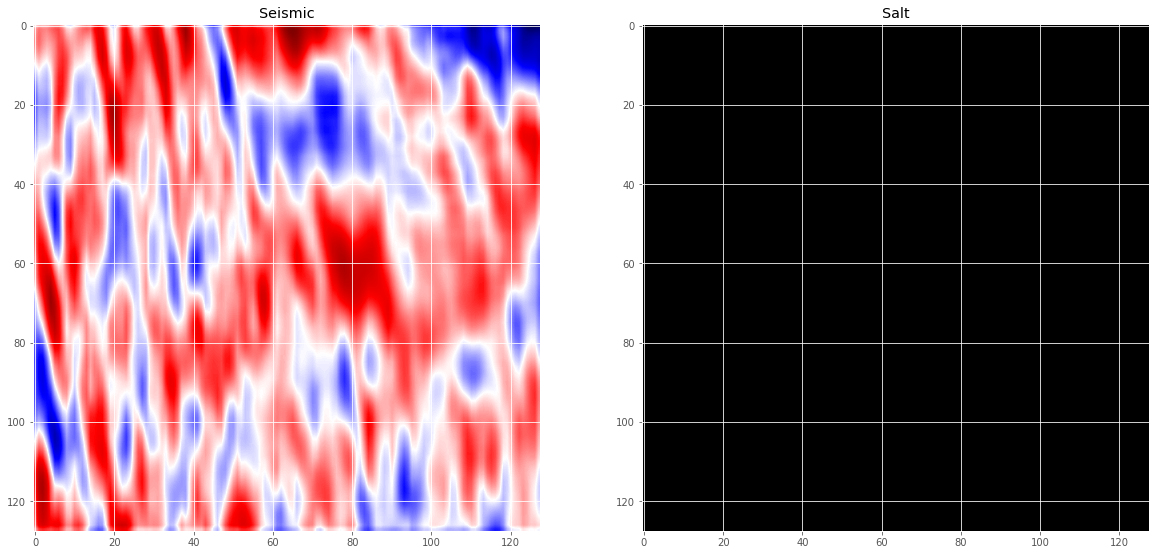

In [33]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [34]:
 def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [35]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [36]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer = 'adam', loss="binary_crossentropy", metrics=["accuracy"])

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [38]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [39]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - 5s 38ms/step - loss: 0.4174 - accuracy: 0.8213 - val_loss: 6.8131 - val_accuracy: 0.2647

Epoch 00001: val_loss improved from inf to 6.81306, saving model to model-tgs-salt.h5
Epoch 2/50
113/113 [==============================] - 4s 36ms/step - loss: 0.3091 - accuracy: 0.8744 - val_loss: 3.0859 - val_accuracy: 0.3736

Epoch 00002: val_loss improved from 6.81306 to 3.08586, saving model to model-tgs-salt.h5
Epoch 3/50
113/113 [==============================] - 4s 36ms/step - loss: 0.2803 - accuracy: 0.8843 - val_loss: 1.4174 - val_accuracy: 0.5759

Epoch 00003: val_loss improved from 3.08586 to 1.41741, saving model to model-tgs-salt.h5
Epoch 4/50
113/113 [==============================] - 4s 36ms/step - loss: 0.2688 - accuracy: 0.8874 - val_loss: 0.6029 - val_accuracy: 0.7192

Epoch 00004: val_loss improved from 1.41741 to 0.60291, saving model to model-tgs-salt.h5
Epoch 5/50
113/113 [==============================] - 4s 36ms/step -

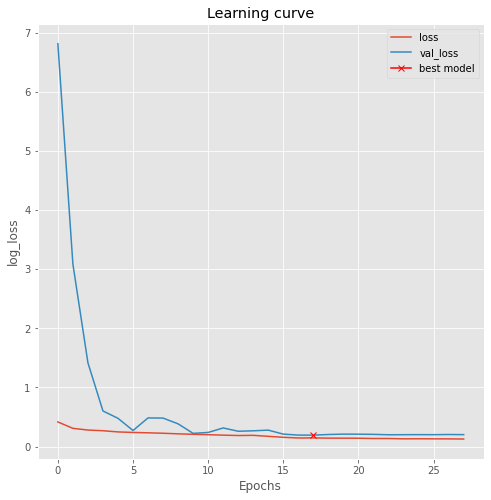

In [40]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

In [41]:


# load the best model
model.load_weights('model-tgs-salt.h5')



     


In [42]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 0s 12ms/step - loss: 0.1943 - accuracy: 0.9150


[0.1943434327840805, 0.9150175452232361]

In [43]:


# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)



     


13/13 [==============================] - 0s 9ms/step


In [44]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [45]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

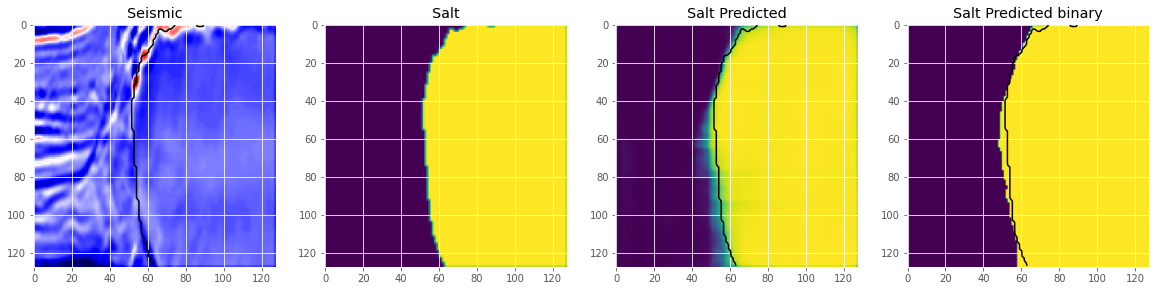

In [46]:


# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)



     


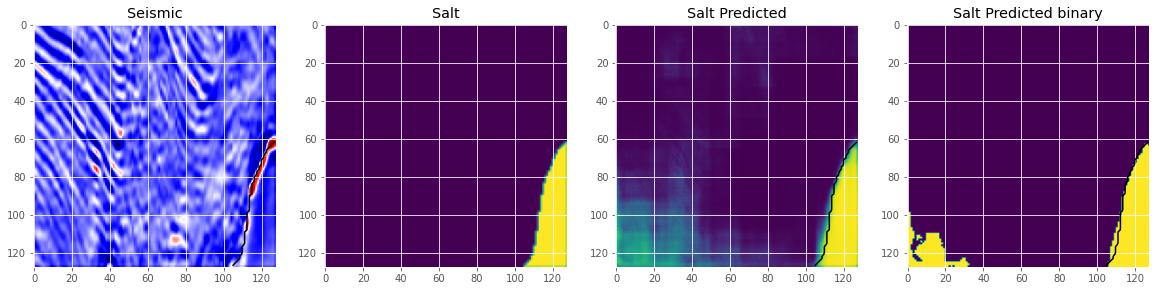

In [47]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

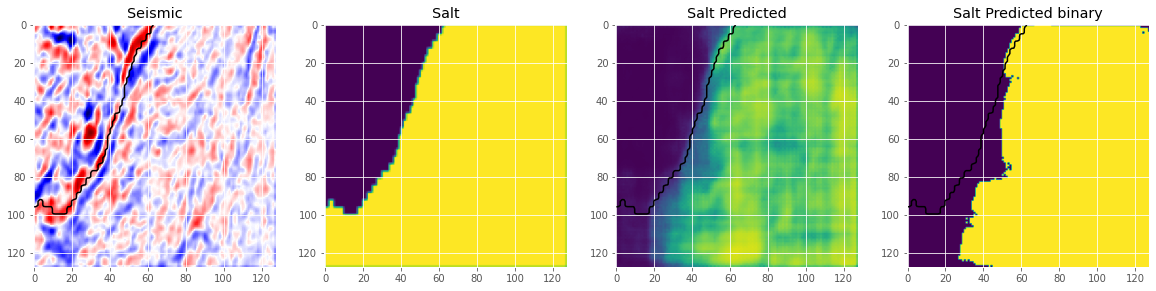

In [48]:


plot_sample(X_valid, y_valid, preds_val, preds_val_t)



     
